In [27]:
pip install yfinance PyPortfolioOpt matplotlib pandas numpy scipy scikit-learn

In [28]:
#Imports and Setup
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Portfolio Optimization
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.objective_functions import L2_reg

from scipy.stats import skew, kurtosis
from numpy.linalg import eigh
import warnings

warnings.filterwarnings("ignore")

In [29]:
#Load Data
tickers = ['SPY', 'IWM', 'EFA', 'EEM', 'AGG', 'LQD', 'HYG', 'TLT', 'GLD', 'VNQ', 'DBC', 'VT', 'XLE', 'XLK', 'UUP']
start_date = "2008-07-01"
end_date = "2025-03-01"

prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Close"].dropna()
daily_returns = prices.pct_change().dropna()

[*********************100%***********************]  15 of 15 completed


In [30]:
#Random Matrix Theory (RMT) to filter out noisy eigenvalues in the covariance matrix.
#implements the Marčenko–Pastur threshold to suppress estimation noise and improve portfolio stability.
def rmt_denoised_covariance(returns, relax=1.0, label=""):
    T, N = returns.shape
    sample_cov = np.cov(returns, rowvar=False)
    eigenvals, eigenvecs = eigh(sample_cov)
    q = T / N
    lambda_plus = (sample_cov.trace() / N) * (1 + 1 / np.sqrt(q))**2 * relax
    filtered = np.clip(eigenvals, None, lambda_plus)
    print(f"[{label}] λ₊ = {lambda_plus:.4f} — Clipped {np.sum(eigenvals > lambda_plus)} eigenvalue(s)")
    return pd.DataFrame(eigenvecs @ np.diag(filtered) @ eigenvecs.T, index=returns.columns, columns=returns.columns)


In [31]:
#Performance Metrics Function
def compute_metrics(port_returns, label):
    metrics = {
        "Mean Return": port_returns.mean(),
        "Annual Return": port_returns.mean() * 252,
        "Geometric Return": (np.prod(1 + port_returns))**(252 / len(port_returns)) - 1,
        "Min Return": port_returns.min(),
        "Max Drawdown (%)": ((1 + port_returns).cumprod() / (1 + port_returns).cumprod().cummax() - 1).min() * 100,
        "Max 10-Day Drawdown (%)": port_returns.rolling(10).sum().min() * 100,
        "Sharpe Ratio": (port_returns.mean() * 252 - 0.05) / (port_returns.std() * np.sqrt(252)),
        "Volatility": port_returns.std() * np.sqrt(252),
        "Skewness": skew(port_returns),
        "Kurtosis": kurtosis(port_returns),
        "VaR (%)": np.percentile(port_returns, 5) * 100,
        "CVaR (%)": port_returns[port_returns <= np.percentile(port_returns, 5)].mean() * 100,
    }
    return pd.Series(metrics, name=label), (1 + port_returns).cumprod()

In [32]:
#Regime-Based Out-of-Sample for RMT Models
# Define training/testing regimes for out-of-sample performance.
# Each regime simulates investing after observing a different market period.

regimes = [("2008-07-01", "2018-12-31", "2019-01-01", "2025-03-01")]
returns_rmt, returns_base, returns_high = [], [], []


In [33]:
# Loop through each regime to compute out-of-sample returns for:
# - RMT with Relaxed λ₊ (1.2), Strict Base (1.0), and Loose High (1.4).
# Each model is optimized with L2 regularization and Sharpe ratio objective.

for train_start, train_end, test_start, test_end in regimes:
    train_prices = prices.loc[train_start:train_end]
    test_prices = prices.loc[test_start:test_end]
    train_returns = train_prices.pct_change().dropna()
    test_returns = test_prices.pct_change().dropna()
    mu_train = mean_historical_return(train_prices, frequency=252)

    for relax, results, label in zip([1.2, 1.0, 1.4], [returns_rmt, returns_base, returns_high], ["RMT", "Base", "High"]):
        try:
            cov = rmt_denoised_covariance(train_returns, relax=relax, label=label)
            ef = EfficientFrontier(mu_train, cov)
            ef.add_objective(L2_reg, gamma=1)
            ef.max_sharpe(risk_free_rate=0.05)
            weights = pd.Series(ef.clean_weights())
            results.append(test_returns @ weights)
        except Exception as e:
            print(f"Error optimizing {label}: {e}")

[RMT] λ₊ = 0.0002 — Clipped 1 eigenvalue(s)
[Base] λ₊ = 0.0002 — Clipped 2 eigenvalue(s)
[High] λ₊ = 0.0003 — Clipped 1 eigenvalue(s)


In [34]:
#Static Models on Full Period
metrics, curves = {}, {}
mu_full = mean_historical_return(prices, frequency=252)
subset = daily_returns.columns[:10]

# MVO-LW
cov_lw = CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(mu_full, cov_lw)
ef.add_objective(L2_reg, gamma=1)
ef.max_sharpe(risk_free_rate=0.05)
weights_lw = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns @ weights_lw, "MVO-LW")
metrics["MVO-LW (Static)"] = m
curves["MVO-LW (Static)"] = c

# Equal-Weighted
equal_weights = pd.Series(1 / len(tickers), index=tickers)
m, c = compute_metrics(daily_returns @ equal_weights, "Equal-Weighted")
metrics["Equal-Weighted"] = m
curves["Equal-Weighted"] = c

# MVO-Naive
sample_cov = np.cov(daily_returns, rowvar=False)
sample_cov_df = pd.DataFrame(sample_cov, index=daily_returns.columns, columns=daily_returns.columns)
ef = EfficientFrontier(mu_full, sample_cov_df)
ef.add_objective(L2_reg, gamma=1)
ef.max_sharpe(risk_free_rate=0.05)
weights_naive = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns @ weights_naive, "MVO-Naive")
metrics["MVO-Naive"] = m
curves["MVO-Naive"] = c

# LW Subset
mu_sub = mean_historical_return(prices[subset], frequency=252)
cov_sub = CovarianceShrinkage(prices[subset]).ledoit_wolf()
ef = EfficientFrontier(mu_sub, cov_sub)
ef.add_objective(L2_reg, gamma=1)
ef.max_sharpe(risk_free_rate=0.05)
weights_sub = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns[subset] @ weights_sub, "LW Subset")
metrics["LW Subset"] = m
curves["LW Subset"] = c


In [35]:
#Add OOS RMT Results
for label, rets in zip(["MVO-RMT (OOS)", "RMT λ₊ Base (OOS)", "RMT λ₊ High (OOS)"], [returns_rmt, returns_base, returns_high]):
    full = pd.concat(rets).sort_index()
    m, c = compute_metrics(full, label)
    metrics[label] = m
    curves[label] = c

In [36]:
#Table
oos_table = pd.concat(metrics.values(), axis=1).round(6)
print("\n--- Final Out-of-Sample Model Comparison Table ---")
display(oos_table)


--- Final Out-of-Sample Model Comparison Table ---


,MVO-LW,Equal-Weighted,MVO-Naive,LW Subset,MVO-RMT (OOS),RMT λ₊ Base (OOS),RMT λ₊ High (OOS)
Mean Return,0.000570,0.000293,0.000554,0.000467,0.000692,0.000692,0.000692
Annual Return,0.143635,0.073729,0.139672,0.117723,0.174387,0.174385,0.174385
Geometric Return,0.130944,0.067275,0.126415,0.106120,0.165348,0.165345,0.165346
Min Return,-0.122822,-0.075298,-0.123968,-0.102243,-0.120596,-0.120595,-0.120592
Max Drawdown (%),-44.093524,-32.633013,-45.047908,-42.533819,-32.117376,-32.117104,-32.116577
Max 10-Day Drawdown (%),-26.277217,-22.892128,-26.444591,-26.150394,-25.142103,-25.141906,-25.141525
Sharpe Ratio,0.462240,0.180936,0.442195,0.369426,0.603769,0.603764,0.603768
Volatility,0.202568,0.131145,0.202790,0.183321,0.206018,0.206016,0.206014
Skewness,-0.167610,-0.236961,-0.204313,-0.293309,-0.559727,-0.559732,-0.559710
Kurtosis,10.948980,15.129334,11.179847,11.053007,11.280939,11.280977,11.280634


In [37]:
# Add Individual ETF Benchmarks
etf_metrics = {}
etf_curves = {}

# Loop through each ETF and calculate full-period metrics assuming 100% allocation
for ticker in daily_returns.columns:
    port_returns = daily_returns[ticker]
    m, c = compute_metrics(port_returns, ticker)
    etf_metrics[ticker] = m
    etf_curves[ticker] = c

# Extended table
all_metrics_combined = pd.concat({**metrics, **etf_metrics}, axis=1).round(6)

# ETF comparison table separately
etf_table = pd.concat(etf_metrics.values(), axis=1).round(6)
print("\n--- Individual ETF Benchmark Performance ---")
display(etf_table)


--- Individual ETF Benchmark Performance ---


,AGG,DBC,EEM,EFA,GLD,HYG,IWM,LQD,SPY,TLT,UUP,VNQ,VT,XLE,XLK
Mean Return,0.000117,-0.000065,0.000231,0.000257,0.000307,0.000233,0.000451,0.000185,0.000519,0.000164,0.000113,0.000460,0.000385,0.000320,0.000710
Annual Return,0.029580,-0.016305,0.058115,0.064776,0.077353,0.058823,0.113679,0.046692,0.130779,0.041354,0.028563,0.115973,0.097089,0.080516,0.178945
Geometric Return,0.028451,-0.034136,0.019438,0.041099,0.064786,0.053780,0.085625,0.043438,0.117267,0.029541,0.025658,0.072344,0.078289,0.033324,0.164096
Min Return,-0.068395,-0.079444,-0.161662,-0.111632,-0.087808,-0.080974,-0.132669,-0.091111,-0.109424,-0.066683,-0.032196,-0.195137,-0.121380,-0.201412,-0.138140
Max Drawdown (%),-18.432925,-76.362636,-58.678438,-52.789221,-45.555013,-30.359715,-53.884060,-24.954855,-47.165228,-48.351137,-22.190956,-66.125067,-49.757513,-71.262777,-44.225689
Max 10-Day Drawdown (%),-10.339800,-24.596089,-41.000798,-32.881850,-23.386499,-21.699189,-38.910087,-23.172136,-30.114944,-11.063234,-9.649845,-38.630199,-31.489389,-60.487794,-25.918922
Sharpe Ratio,-0.370742,-0.346080,0.029035,0.066805,0.160281,0.077662,0.254228,-0.036247,0.405481,-0.055241,-0.266775,0.217584,0.226442,0.099059,0.555487
Volatility,0.055080,0.191590,0.279496,0.221186,0.170658,0.113603,0.250479,0.091272,0.199219,0.156517,0.080355,0.303208,0.207953,0.308059,0.232130
Skewness,-2.010029,-0.443811,0.686137,-0.032935,-0.085030,0.764690,-0.379366,0.053320,-0.082267,0.096349,-0.018818,-0.021190,-0.344436,-0.273790,-0.015036
Kurtosis,52.367663,3.618402,21.604121,14.388465,7.459103,41.676704,6.467466,57.593932,14.683934,3.131745,3.642574,17.283111,12.813016,12.761130,9.376944


In [38]:
#Combined Metrics Table

# Combine all model metrics (already stored in `metrics`) and ETF benchmarks (`etf_metrics`)
metrics_table = pd.concat(
    list(metrics.values()) + list(etf_metrics.values()),
    axis=1
).round(6)

print("\n--- Full Metrics Table: Models + ETFs ---")
display(metrics_table)


--- Full Metrics Table: Models + ETFs ---


,MVO-LW,Equal-Weighted,MVO-Naive,LW Subset,MVO-RMT (OOS),RMT λ₊ Base (OOS),RMT λ₊ High (OOS),AGG,DBC,EEM,...,HYG,IWM,LQD,SPY,TLT,UUP,VNQ,VT,XLE,XLK
Mean Return,0.000570,0.000293,0.000554,0.000467,0.000692,0.000692,0.000692,0.000117,-0.000065,0.000231,...,0.000233,0.000451,0.000185,0.000519,0.000164,0.000113,0.000460,0.000385,0.000320,0.000710
Annual Return,0.143635,0.073729,0.139672,0.117723,0.174387,0.174385,0.174385,0.029580,-0.016305,0.058115,...,0.058823,0.113679,0.046692,0.130779,0.041354,0.028563,0.115973,0.097089,0.080516,0.178945
Geometric Return,0.130944,0.067275,0.126415,0.106120,0.165348,0.165345,0.165346,0.028451,-0.034136,0.019438,...,0.053780,0.085625,0.043438,0.117267,0.029541,0.025658,0.072344,0.078289,0.033324,0.164096
Min Return,-0.122822,-0.075298,-0.123968,-0.102243,-0.120596,-0.120595,-0.120592,-0.068395,-0.079444,-0.161662,...,-0.080974,-0.132669,-0.091111,-0.109424,-0.066683,-0.032196,-0.195137,-0.121380,-0.201412,-0.138140
Max Drawdown (%),-44.093524,-32.633013,-45.047908,-42.533819,-32.117376,-32.117104,-32.116577,-18.432925,-76.362636,-58.678438,...,-30.359715,-53.884060,-24.954855,-47.165228,-48.351137,-22.190956,-66.125067,-49.757513,-71.262777,-44.225689
Max 10-Day Drawdown (%),-26.277217,-22.892128,-26.444591,-26.150394,-25.142103,-25.141906,-25.141525,-10.339800,-24.596089,-41.000798,...,-21.699189,-38.910087,-23.172136,-30.114944,-11.063234,-9.649845,-38.630199,-31.489389,-60.487794,-25.918922
Sharpe Ratio,0.462240,0.180936,0.442195,0.369426,0.603769,0.603764,0.603768,-0.370742,-0.346080,0.029035,...,0.077662,0.254228,-0.036247,0.405481,-0.055241,-0.266775,0.217584,0.226442,0.099059,0.555487
Volatility,0.202568,0.131145,0.202790,0.183321,0.206018,0.206016,0.206014,0.055080,0.191590,0.279496,...,0.113603,0.250479,0.091272,0.199219,0.156517,0.080355,0.303208,0.207953,0.308059,0.232130
Skewness,-0.167610,-0.236961,-0.204313,-0.293309,-0.559727,-0.559732,-0.559710,-2.010029,-0.443811,0.686137,...,0.764690,-0.379366,0.053320,-0.082267,0.096349,-0.018818,-0.021190,-0.344436,-0.273790,-0.015036
Kurtosis,10.948980,15.129334,11.179847,11.053007,11.280939,11.280977,11.280634,52.367663,3.618402,21.604121,...,41.676704,6.467466,57.593932,14.683934,3.131745,3.642574,17.283111,12.813016,12.761130,9.376944


In [39]:
import matplotlib.pyplot as plt

# These are the exact column names as used in your current metrics_table
model_columns = [
    "MVO-RMT (OOS)",
    "MVO-LW",
    "Equal-Weighted",
    "RMT λ₊ Base (OOS)",
    "RMT λ₊ High (OOS)",
    "LW Subset",
    "MVO-Naive"
]

# Extract and round
filtered_table = metrics_table[model_columns].round(6)

# Display the filtered table
print("\n--- MVO Model Comparison Table (Rounded to 6 decimals) ---")
display(filtered_table)


--- MVO Model Comparison Table (Rounded to 6 decimals) ---


,MVO-RMT (OOS),MVO-LW,Equal-Weighted,RMT λ₊ Base (OOS),RMT λ₊ High (OOS),LW Subset,MVO-Naive
Mean Return,0.000692,0.000570,0.000293,0.000692,0.000692,0.000467,0.000554
Annual Return,0.174387,0.143635,0.073729,0.174385,0.174385,0.117723,0.139672
Geometric Return,0.165348,0.130944,0.067275,0.165345,0.165346,0.106120,0.126415
Min Return,-0.120596,-0.122822,-0.075298,-0.120595,-0.120592,-0.102243,-0.123968
Max Drawdown (%),-32.117376,-44.093524,-32.633013,-32.117104,-32.116577,-42.533819,-45.047908
Max 10-Day Drawdown (%),-25.142103,-26.277217,-22.892128,-25.141906,-25.141525,-26.150394,-26.444591
Sharpe Ratio,0.603769,0.462240,0.180936,0.603764,0.603768,0.369426,0.442195
Volatility,0.206018,0.202568,0.131145,0.206016,0.206014,0.183321,0.202790
Skewness,-0.559727,-0.167610,-0.236961,-0.559732,-0.559710,-0.293309,-0.204313
Kurtosis,11.280939,10.948980,15.129334,11.280977,11.280634,11.053007,11.179847


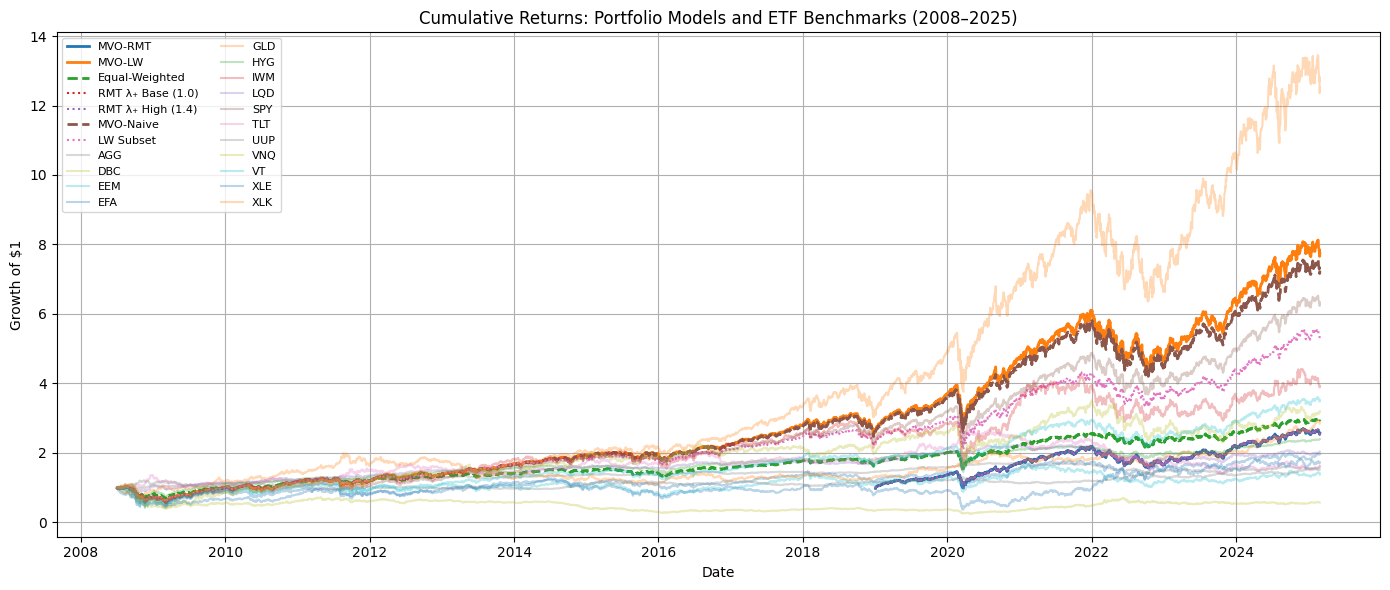

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Main Models
plt.plot(curves["MVO-RMT (OOS)"], label="MVO-RMT", linewidth=2)
plt.plot(curves["MVO-LW (Static)"], label="MVO-LW", linewidth=2)
plt.plot(curves["Equal-Weighted"], label="Equal-Weighted", linewidth=2, linestyle="--")

#RMT Sensitivity Models
plt.plot(curves["RMT λ₊ Base (OOS)"], label="RMT λ₊ Base (1.0)", linestyle=":")
plt.plot(curves["RMT λ₊ High (OOS)"], label="RMT λ₊ High (1.4)", linestyle=":")

# Other Benchmarks
plt.plot(curves["MVO-Naive"], label="MVO-Naive", linestyle="--", linewidth=2)
plt.plot(curves["LW Subset"], label="LW Subset", linestyle=":")

#ETF Benchmark Curves
for ticker, curve in etf_curves.items():
    plt.plot(curve, label=ticker, alpha=0.3)

#Formatting
plt.title("Cumulative Returns: Portfolio Models and ETF Benchmarks (2008–2025)")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend(fontsize=8, loc="upper left", ncol=2)
plt.grid(True)
plt.tight_layout()

plt.savefig("cumulative_returns_plot.png", dpi=300)
plt.show()

In [41]:
# Recompute final weights from last regime
train_start, train_end, test_start, test_end = regimes[-1]  # Get the last regime
train_prices = prices.loc[train_start:train_end]
train_returns = train_prices.pct_change().dropna()
mu_last = mean_historical_return(train_prices, frequency=252)

# Final weights
cov_rmt = rmt_denoised_covariance(train_returns, relax=1.2)
cov_base = rmt_denoised_covariance(train_returns, relax=1.0)
cov_high = rmt_denoised_covariance(train_returns, relax=1.4)

ef_rmt = EfficientFrontier(mu_last, cov_rmt)
ef_rmt.add_objective(L2_reg, gamma=1)
ef_rmt.max_sharpe(risk_free_rate=0.05)
weights_rmt_final = pd.Series(ef_rmt.clean_weights())

ef_base = EfficientFrontier(mu_last, cov_base)
ef_base.add_objective(L2_reg, gamma=1)
ef_base.max_sharpe(risk_free_rate=0.05)
weights_base_final = pd.Series(ef_base.clean_weights())

ef_high = EfficientFrontier(mu_last, cov_high)
ef_high.add_objective(L2_reg, gamma=1)
ef_high.max_sharpe(risk_free_rate=0.05)
weights_high_final = pd.Series(ef_high.clean_weights())

[] λ₊ = 0.0002 — Clipped 1 eigenvalue(s)
[] λ₊ = 0.0002 — Clipped 2 eigenvalue(s)
[] λ₊ = 0.0003 — Clipped 1 eigenvalue(s)


In [42]:
print("\nFinal Weights (MVO-RMT):")
print(weights_rmt_final.sort_values(ascending=False).round(4))

print("\nFinal Weights (RMT λ₊ Base):")
print(weights_base_final.sort_values(ascending=False).round(4))

print("\nFinal Weights (RMT λ₊ High):")
print(weights_high_final.sort_values(ascending=False).round(4))


Final Weights (MVO-RMT):
XLK    0.3940
SPY    0.2173
IWM    0.1775
VNQ    0.1133
TLT    0.0527
HYG    0.0314
LQD    0.0114
VT     0.0024
EFA    0.0000
DBC    0.0000
EEM    0.0000
AGG    0.0000
GLD    0.0000
UUP    0.0000
XLE    0.0000
dtype: float64

Final Weights (RMT λ₊ Base):
XLK    0.3940
SPY    0.2173
IWM    0.1775
VNQ    0.1133
TLT    0.0527
HYG    0.0314
LQD    0.0114
VT     0.0024
EFA    0.0000
DBC    0.0000
EEM    0.0000
AGG    0.0000
GLD    0.0000
UUP    0.0000
XLE    0.0000
dtype: float64

Final Weights (RMT λ₊ High):
XLK    0.3940
SPY    0.2173
IWM    0.1775
VNQ    0.1133
TLT    0.0527
HYG    0.0314
LQD    0.0114
VT     0.0024
EFA    0.0000
DBC    0.0000
EEM    0.0000
AGG    0.0000
GLD    0.0000
UUP    0.0000
XLE    0.0000
dtype: float64


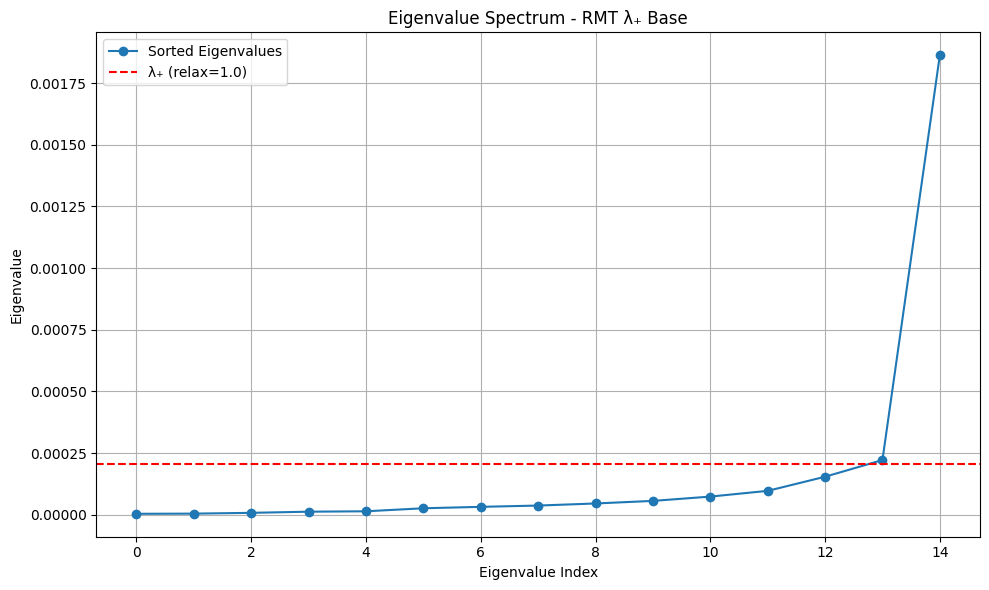

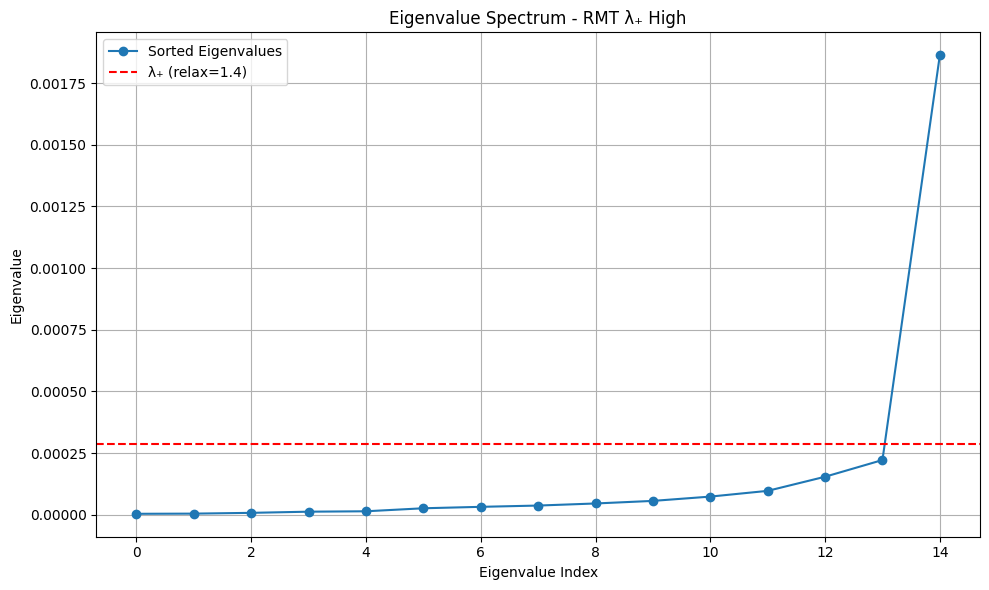

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Eigenvalue Spectrum Diagnostic Plot
def plot_eigenvalue_spectrum(returns, relax=1.0, label=""):
    """
    Plot the sorted eigenvalues of the sample covariance matrix,
    along with the Marčenko–Pastur λ₊ threshold.
    """
    T, N = returns.shape
    sample_cov = np.cov(returns, rowvar=False)
    eigenvals = np.sort(np.linalg.eigvalsh(sample_cov))  # sort for better visual

    # Calculate Marčenko–Pastur threshold
    q = T / N
    lambda_plus = (sample_cov.trace() / N) * (1 + 1 / np.sqrt(q))**2 * relax

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvals, marker='o', label='Sorted Eigenvalues')
    plt.axhline(y=lambda_plus, color='red', linestyle='--', label=f'λ₊ (relax={relax})')
    plt.title(f"Eigenvalue Spectrum - {label}")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Get training returns from last regime
last_train_start, last_train_end, _, _ = regimes[-1]
last_train_prices = prices.loc[last_train_start:last_train_end]
last_train_returns = last_train_prices.pct_change().dropna()

#Plot Eigenvalue Spectra for Base and High λ₊ RMT
plot_eigenvalue_spectrum(last_train_returns, relax=1.0, label="RMT λ₊ Base")
plot_eigenvalue_spectrum(last_train_returns, relax=1.4, label="RMT λ₊ High")

In [44]:
filtered_table.to_csv("mvo_model_comparison_table.csv")